# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

**Вариант 2: задания 1 и 2 на наборе данных MNIST**

Вариант 3: задания 1 и 3 на наборе данных CIFAR-10

Вариант 4: задания 1 и 3 на наборе данных MNIST

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере.

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
cifar10 = tf.keras.datasets.cifar10


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST
sklearn.datasets import load_digits
digits = load_digits()

In [2]:
# Load in the data
from keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_training = 5000
train_subsample = list(range(num_training))
x_train = x_train[train_subsample]
y_train = y_train[train_subsample]

num_test = 500
test_subsample = list(range(num_test))
x_test = x_test[test_subsample]
y_test = y_test[test_subsample]

# assert x_train.shape == (50000, 32, 32, 3)
# assert x_test.shape == (10000, 32, 32, 3)
# assert y_train.shape == (50000, 1)
# assert y_test.shape == (10000, 1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(5000, 28, 28) (5000,) (500, 28, 28) (500,)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



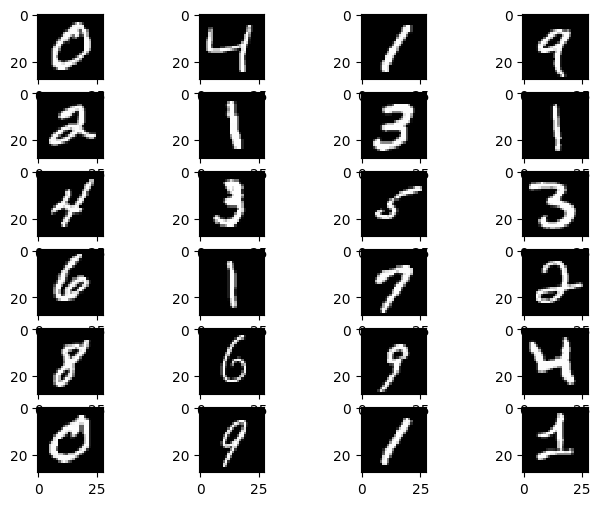

In [3]:
plt.figure(figsize=(8, 8))
for i in range(1, 25):
  plt.subplot(8, 4, i)
  plt.imshow(x_train[i])

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив.

In [4]:
def reshape_to_vectors(arr):
    return arr.reshape(arr.shape[0], -1)

x_train, y_train, x_test, y_test = map(reshape_to_vectors, [x_train, y_train, x_test, y_test])
print(x_train[0].shape, y_train[0].shape, x_test[0].shape, y_test[0].shape)


(784,) (1,) (784,) (1,)


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке.

In [5]:
from classifiers.KNN import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(x_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [6]:
dists = classifier.compute_distances_one_loop(x_test)
print(dists.shape)
num_test = x_test.shape[0]

(500, 5000)


In [7]:
y_test_pred = classifier.predict_labels(dists, k=3)
y_test = np.reshape(y_test, (500,)).astype('float32')


1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки.


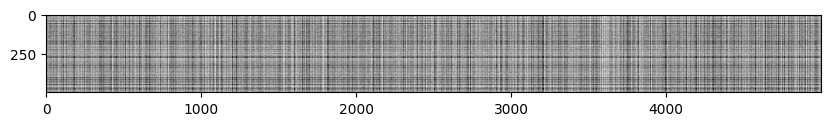

In [8]:
plt.imshow(dists, interpolation='none')
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [9]:
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 102 / 500 correct => accuracy: 0.204000


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

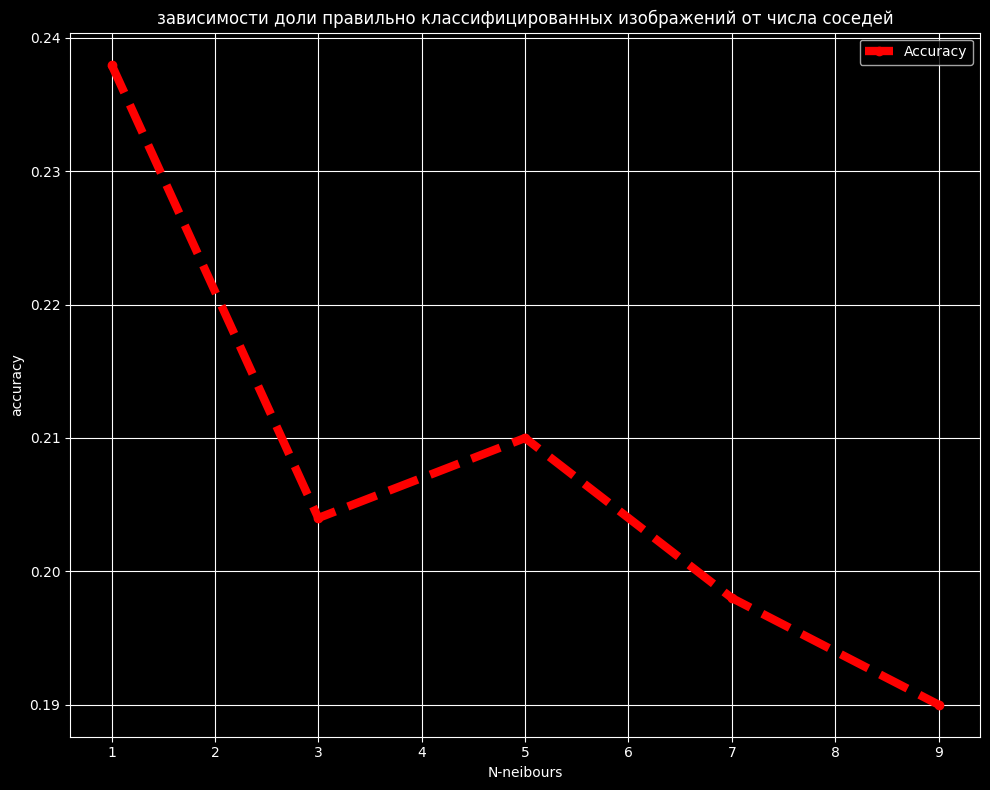

In [10]:
neighbors_k = np.arange(1, 11, 2).tolist()
neighbors_k
nums = np.arange(len(neighbors_k))
scores = []
for n in neighbors_k:
  clf = KNearestNeighbor()
  clf.train(x_train, y_train)
  y_test_pred = clf.predict_labels(dists, k=n)
  accuracy_n = sum((y_test_pred==y_test).astype(float)) / num_test
  scores.append(accuracy_n)

plt.style.use('dark_background')

plt.plot(neighbors_k, scores, color="r", linestyle="--",linewidth=6,marker="o", label= "Accuracy")

plt.title("зависимости доли правильно классифицированных изображений от числа соседей")
plt.xlabel("N-neibours")
plt.ylabel("accuracy")

plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [11]:
import copy

def cross_validation(X, y, k, clf, folds=7):
    clf.train(x_train, y_train)
    val = np.array_split(X, folds)
    target = np.array_split(y, folds)
    results = []
    for fold in range(folds):
        one_x, one_y = val[fold], target[fold]
        one_x, one_y = np.array(copy.deepcopy(one_x)), np.array(copy.deepcopy(one_y))
        one_y = np.reshape(one_y, (one_y.shape[0],)).astype('float32')
        # rest_x, rest_y = val[:fold] + val[fold + 1:], target[:fold] + target[fold + 1:]
        # clf.train(rest_x, rest_y)
        dist = clf.compute_distances_one_loop(one_x)
        predicted = clf.predict_labels(dist, k=k).astype(int)

        cross_val_score = sum((predicted==one_y).astype(float)) / num_test
        results.append(cross_val_score)
        
    print(results)
    return np.mean(results)



classifier = KNearestNeighbor()
# print(f'Cross Validation result: {cross_validation(x_train, y_train, 7, classifier)}')
k_best = [cross_validation(x_train, y_train, x, classifier) for x in neighbors_k]

print(f'Cross Validation results (from 1 to 9 in 2): {k_best}\nBest k {neighbors_k[k_best.index(max(k_best))]} with value {max(k_best)}')


[1.43, 1.43, 1.428, 1.428, 1.428, 1.428, 1.428]
[0.574, 0.56, 0.624, 0.554, 0.57, 0.548, 0.58]
[0.468, 0.436, 0.466, 0.43, 0.444, 0.446, 0.43]
[0.408, 0.384, 0.398, 0.382, 0.4, 0.416, 0.376]
[0.37, 0.352, 0.364, 0.344, 0.362, 0.352, 0.348]
Cross Validation results (from 1 to 9 in 2): [1.4285714285714286, 0.5728571428571428, 0.4457142857142858, 0.39485714285714285, 0.3559999999999999]
Best k 1 with value 1.4285714285714286



1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [12]:
classifier = KNearestNeighbor()
classifier.train(x_train, y_train)
dists = classifier.compute_distances_one_loop(x_test)
print(dists.shape)
num_test = x_test.shape[0]
best_kval = neighbors_k[k_best.index(max(k_best))]
y_test_pred = classifier.predict_labels(dists, k=best_kval)
y_test = np.reshape(y_test, (500,)).astype('float32')

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

(500, 5000)
Got 119 / 500 correct => accuracy: 0.238000


1.11 Сделайте выводы по результатам 1 части задания.

Классификатор KNN на датасете MNIST показывает чрезвычайно низкую точность, при __k=1__ значение метрики accuracy равняется __0.24__, при этом значения accuracy на другом количестве соседей еще ниже. Ко всему прочему скорость работы алгоритма в данной задаче также очень низкая, а требования к мощностям высокие (из за чего делить выборку на части и работать не на полном наборе данных)Что делает KNN в данной задаче крайне неэффективным решением.

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [13]:
from keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# assert x_train.shape == (50000, 32, 32, 3)
# assert x_test.shape == (10000, 32, 32, 3)
# assert y_train.shape == (50000, 1)
# assert y_test.shape == (10000, 1)

num_training = 5000
val_shape = 0.3 *  y_train.shape[0]
train_subsample = list(range(num_training))
x_train, x_val =  np.array_split(x_train, [int(val_shape)])
y_train, y_val = np.array_split(y_train, [int(val_shape)])

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(18000, 28, 28) (18000,) (42000, 28, 28) (42000,) (10000, 28, 28) (10000,)


In [14]:

x_train, x_val, x_test = map(reshape_to_vectors, [x_train, x_val, x_test])
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)
print(x_train[0].shape, y_train[0].shape, x_val[0].shape, y_val[0].shape, x_test[0].shape, y_test[0].shape)


(18000, 784) (18000,) (42000, 784) (42000,) (10000, 784) (10000,)
(784,) () (784,) () (784,) ()


2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

In [15]:
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10])

x_train = x_train.astype('uint8')
x_val = x_val.astype('uint8')
x_test = x_test.astype('uint8')

x_train = np.subtract(x_train, mean_image, out=x_train, casting="unsafe")

x_val = np.subtract(x_val, mean_image, out=x_val, casting="unsafe")

x_test = np.subtract(x_test, mean_image, out=x_test, casting="unsafe")


x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_val = np.hstack([x_val, np.ones((x_val.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])


print(x_train.shape, x_test.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(18000, 785) (10000, 785)


2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



Две основные концепции построение оптимальной разделяющей поверхности с помощью отступа (максимизирует зазор между классами)

- Нахождение точек у которых margin <= 1 или margin >= -1

![image.png](attachment:image.png)

In [16]:

from classifiers.SVM import svm_loss_naive, svm_loss_vectorized
import time


W = np.random.randn(x_train.shape[1], 10) * 0.0001

loss, grad = svm_loss_naive(W, x_train, y_train, 0.000005)
print(f'loss: {loss}')

loss: 9.033597426245617



2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [17]:

loss, grad = svm_loss_naive(W, x_train, y_train, 0.0)

from classifiers.gradient_check import grad_check_sparse

f = lambda w: svm_loss_naive(w, x_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)


loss, grad = svm_loss_naive(W, x_train, y_train, 5e1)
f = lambda w: svm_loss_naive(w, x_train, y_train, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 0.009278 analytic: 0.009278, relative error: 3.077463e-09
numerical: 20.036014 analytic: 20.028389, relative error: 1.903333e-04


c:\Users\gleba\OneDrive\Документы\Applied Math&CS 3 semester\DL\HW1\classifiers\gradient_check.py:126: RuntimeWarning: invalid value encountered in scalar divide
  rel_error = abs(grad_numerical - grad_analytic) / (


numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 23.894861 analytic: 23.881389, relative error: 2.819917e-04
numerical: -9.427489 analytic: -9.425444, relative error: 1.084352e-04
numerical: 30.520706 analytic: 30.517222, relative error: 5.707809e-05
numerical: -9.430981 analytic: -9.431056, relative error: 3.973559e-06
numerical: -137.611900 analytic: -137.597500, relative error: 5.232350e-05
numerical: -15.104663 analytic: -15.111333, relative error: 2.207453e-04
numerical: -31.587640 analytic: -31.610278, relative error: 3.582093e-04
numerical: 0.045718 analytic: 0.045718, relative error: 4.409071e-10
numerical: 6.998030 analytic: 7.002838, relative error: 3.433489e-04
numerical: 0.109335 analytic: 0.109335, relative error: 1.803425e-10
numerical: -9.720093 analytic: -9.721234, relative error: 5.864695e-05
numerical: 0.082874 analytic: 0.082874, relative error: 6.702426e-10
numerical: -8.779958 analytic: -8.779958, relative error: 1.201817e-10
numerical: 0.1274

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [18]:
tic = time.time()
W = W.astype('float16')
x_train = x_train.astype('float16')
y_train = y_train.astype('int16')
_, grad_naive = svm_loss_naive(W, x_train, y_train, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, x_train, y_train, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 6.951548s


c:\Users\gleba\Python 3.11\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Vectorized loss and gradient: computed in 2.876399s
difference: 0.000000


2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [19]:
from classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 218.345112
iteration 100 / 1500: loss 78.256321
iteration 200 / 1500: loss 32.843637
iteration 300 / 1500: loss 16.397767
iteration 400 / 1500: loss 11.230793
iteration 500 / 1500: loss 8.659777
iteration 600 / 1500: loss 8.510977
iteration 700 / 1500: loss 7.412828
iteration 800 / 1500: loss 7.488708
iteration 900 / 1500: loss 7.771724
iteration 1000 / 1500: loss 7.603907
iteration 1100 / 1500: loss 7.982142
iteration 1200 / 1500: loss 8.477668
iteration 1300 / 1500: loss 7.260606
iteration 1400 / 1500: loss 8.313988
That took 5.843702s


In [20]:
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(x_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.350667
validation accuracy: 0.344262


2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [21]:
def cross_validation_svm(X, y, clf, learning_rate, reg, folds=7):
    clf.train(x_train, y_train, learning_rate, reg)
    val = np.array_split(X, folds)
    target = np.array_split(y, folds)
    results = []
    for fold in range(folds):
        one_x, one_y = val[fold], target[fold]
        one_x, one_y = np.array(copy.deepcopy(one_x)), np.array(copy.deepcopy(one_y))
        one_y = np.reshape(one_y, (one_y.shape[0],)).astype('float32')
        predicted = clf.predict(one_x).astype(int)

        cross_val_score = sum((predicted==one_y).astype(float)) / num_test
        results.append(cross_val_score)
        
    print(results)
    return np.mean(results)

In [26]:
import itertools
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

combos = list(itertools.product(learning_rates, regularization_strengths))

classifier = LinearSVM()
best_lr_reg = [cross_validation_svm(x_train, y_train, classifier, x, y) for x, y in combos]

print(f'Cross Validation results: {best_lr_reg}\nBest pair of learning rate and regularization strength is {combos[best_lr_reg.index(max(best_lr_reg))]} with value {np.mean(best_lr_reg)}')


[0.852, 0.834, 0.796, 0.856, 0.812, 0.754, 0.788]
[0.872, 0.872, 0.884, 0.908, 0.872, 0.832, 0.798]
[0.524, 0.508, 0.516, 0.532, 0.492, 0.496, 0.474]
[0.524, 0.508, 0.516, 0.532, 0.492, 0.496, 0.474]
Cross Validation results: [0.8131428571428572, 0.8625714285714287, 0.506, 0.506]
Best pair of learning rate and regularization strength is (1e-07, 50000.0) with value 0.6719285714285714


2.9 Сделайте выводы по второй части задания

Linear SVM в задаче классификации изображений превосходит по точности и по скорости KNN. Однако значение метрики accuracy на датасете MNIST все рано ниже __0.5__ что делает классификацию случайной

## 3.  Построение softmax-классификатора

Его я не делал(

3.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

x_train, x_val =  np.array_split(x_train, [30000])
y_train, y_val = np.array_split(y_train, [30000])

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

In [ ]:
x_train, x_val, x_test = map(reshape_to_vectors, [x_train, x_val, x_test])
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)
print(x_train[0].shape, y_train[0].shape, x_val[0].shape, y_val[0].shape, x_test[0].shape, y_test[0].shape)


3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

In [ ]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8'))
plt.show()


X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
x_train = np.subtract(x_train, mean_image, out=x_train, casting="unsafe")
x_val = np.subtract(x_val, mean_image, out=x_val, casting="unsafe")
x_test = np.subtract(x_test, mean_image, out=x_test, casting="unsafe")




X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])


print(X_train.shape, X_val.shape, X_test.shape)

3.4 Реализуйте функции в classifiers/softmax.py




In [ ]:
from classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [ ]:
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)


from gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = softmax_loss_naive(W, X_train, y_train, 5e1)
f = lambda w: softmax_loss_naive(w, X_train, y_train, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [ ]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

3.8 Обучите Softmax-классификатор и оцените accuracy на тестовой выборке.

3.9 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [ ]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

3.10 Сделайте выводы по третьей части задания